In [1]:
# Install Pyro if needed
!pip install pyro-ppl torch pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# --- Imports ---
import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.poutine import trace, block, replay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd




/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


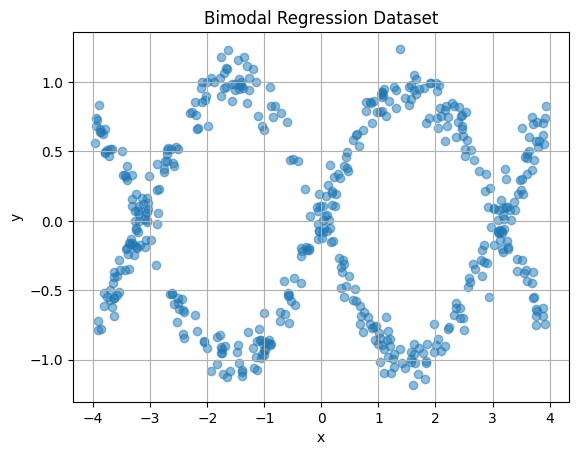

In [3]:
# ---- 1. Dataset ----
def generate_bimodal_data(n_points=500, noise_std=0.1, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(-4, 4, size=(n_points, 1))
    y = []
    for x in X:
        if np.random.rand() < 0.5:
            y_val = np.sin(x) + np.random.normal(0, noise_std)
        else:
            y_val = -np.sin(x) + np.random.normal(0, noise_std)
        y.append(y_val)
    return X, np.array(y).reshape(-1, 1)

X, y = generate_bimodal_data()


# Quick plot to verify visually
plt.scatter(X, y, alpha=0.5)
plt.title("Bimodal Regression Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [4]:
# --- Data Preprocessing ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = map(lambda d: torch.tensor(d, dtype=torch.float32), [X_train, X_test])
y_train, y_test = map(lambda d: torch.tensor(d, dtype=torch.float32).squeeze(), [y_train, y_test])
input_dim = X.shape[1]


In [5]:
# ---- 2. Model and Guide ----
class BayesianNN(pyro.nn.PyroModule):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = pyro.nn.PyroModule[torch.nn.Linear](input_dim, 16)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([16, input_dim]).to_event(2))
        self.fc1.bias = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([16]).to_event(1))
        self.fc2 = pyro.nn.PyroModule[torch.nn.Linear](16, 1)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([1, 16]).to_event(2))
        self.fc2.bias = pyro.nn.PyroSample(dist.Normal(0., 1.))

    def forward(self, X, y=None):
        x = F.relu(self.fc1(X))
        mean = self.fc2(x).squeeze(-1)
        sigma = 0.1
        with pyro.plate("data", X.shape[0]):
            pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean


In [6]:
# --- Guide for each boosting component ---
def make_guide(input_dim, component_id):
    def guide(X, y=None):
        pyro.sample("fc1.weight", dist.Normal(
            pyro.param(f"fc1_w_loc_{component_id}", torch.randn(16, input_dim)),
            pyro.param(f"fc1_w_scale_{component_id}", torch.ones(16, input_dim), constraint=dist.constraints.positive)
        ).to_event(2))
        pyro.sample("fc1.bias", dist.Normal(
            pyro.param(f"fc1_b_loc_{component_id}", torch.randn(16)),
            pyro.param(f"fc1_b_scale_{component_id}", torch.ones(16), constraint=dist.constraints.positive)
        ).to_event(1))
        pyro.sample("fc2.weight", dist.Normal(
            pyro.param(f"fc2_w_loc_{component_id}", torch.randn(1, 16)),
            pyro.param(f"fc2_w_scale_{component_id}", torch.ones(1, 16), constraint=dist.constraints.positive)
        ).to_event(2))
        pyro.sample("fc2.bias", dist.Normal(
            pyro.param(f"fc2_b_loc_{component_id}", torch.tensor(0.)),
            pyro.param(f"fc2_b_scale_{component_id}", torch.tensor(1.), constraint=dist.constraints.positive)
        ))
    return guide



In [7]:
def make_approximation_fn(components, weights):
    """
    Returns a callable that mimics a mixture of BNN components using their guides.
    Used in RELBO to discourage overlapping with current posterior.
    """
    def approximation(X, y=None):
        # Sample an index based on the categorical weights
        idx = pyro.sample("assignment", dist.Categorical(weights)).item()
        _, guide = components[idx]
        return guide(X, y)
    
    return approximation


In [8]:
# ---- 3. RELBO loss ----
def relbo_bnn(model, guide, *args, approximation_fn=None, **kwargs):
    traced_guide = pyro.poutine.trace(guide).get_trace(*args, **kwargs)
    elbo = pyro.infer.Trace_ELBO(max_plate_nesting=1)
    loss_fn = elbo.differentiable_loss(model, guide, *args, **kwargs)

    approx_trace = pyro.poutine.trace(
        pyro.poutine.replay(
            pyro.poutine.block(approximation_fn, expose=["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias"]),
            traced_guide  # ✅ passed as positional arg
        )
    ).get_trace(*args, **kwargs)

    relbo = -loss_fn - approx_trace.log_prob_sum()
    return -relbo



In [9]:
def train_boosting_vi(X_train, y_train, n_components=2, epochs=2000, patience=300):
    components, weights = [], torch.tensor([1.0])
    residual_target = y_train.clone().detach()

    for i in range(n_components):
        print(f"\n🔁 Training Component {i+1}/{n_components}")
        pyro.clear_param_store()
        model_i = BayesianNN(input_dim)
        guide_i = make_guide(input_dim, i)
        optimizer = Adam({"lr": 0.01})

        if i == 0:
            svi = SVI(model_i, guide_i, optimizer, loss=Trace_ELBO())
        else:
            approximation_fn = make_approximation_fn(components, weights)

            def relbo_loss_fn(model_unused, guide_unused, X_batch, y_batch):
                return relbo_bnn(model_i, guide_i, X_batch, y_batch, approximation_fn=approximation_fn)


            svi = SVI(model_i, guide_i, optimizer, loss=relbo_loss_fn)

        best_loss, no_improve = float("inf"), 0
        for epoch in range(epochs):
            clipped_residual = torch.clamp(residual_target, -1.5, 1.5)
            loss = svi.step(X_train, clipped_residual)

            if loss < best_loss:
                best_loss, no_improve = loss, 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            if epoch % 200 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        components.append((model_i, guide_i))
        weights = torch.ones(len(components)) / len(components)

        with torch.no_grad():
            predictive = Predictive(model_i, guide=guide_i, num_samples=50)
            samples = predictive(X_train)["obs"]
            residual_target -= samples.mean(0)

    return components, weights



In [10]:
# ---- 5. Approximation wrapper ----
def make_approximation_fn(components, weights):
    def approximation_fn(X, y=None):
        idx = pyro.sample("assignment", dist.Categorical(weights)).item()
        _, guide = components[idx]
        return guide(X, y)
    return approximation_fn

In [11]:
# ---- 6. Plotting helpers ----
def plot_predictive_distribution(X_test, y_test, mean_preds, std_preds):
    x_plot = X_test.numpy().flatten()
    y_true = y_test.numpy()
    sorted_idx = np.argsort(x_plot)
    plt.figure(figsize=(10, 5))
    plt.plot(x_plot[sorted_idx], y_true[sorted_idx], 'k.', label='True y')
    plt.plot(x_plot[sorted_idx], mean_preds[sorted_idx], 'b-', label='Predicted mean')
    plt.fill_between(
        x_plot[sorted_idx],
        mean_preds[sorted_idx] - 2 * std_preds[sorted_idx],
        mean_preds[sorted_idx] + 2 * std_preds[sorted_idx],
        color='blue',
        alpha=0.2,
        label='±2 std'
    )
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
def plot_component_predictions(components, X_grid):
    plt.figure(figsize=(10, 6))
    X_tensor = torch.tensor(X_grid, dtype=torch.float32)
    for idx, (model, guide) in enumerate(components):
        predictive = Predictive(model, guide=guide, num_samples=100)
        samples = predictive(X_tensor)["obs"]
        plt.plot(X_grid, samples.mean(dim=0).detach().numpy(), label=f'Component {idx+1}')
    plt.title("Mean Predictions from Each Boosting Component")
    plt.grid(True)
    plt.legend()
    plt.show()


In [13]:
# --- Plot Component Predictions ---
def plot_component_predictions(components, X_grid):
    plt.figure(figsize=(10, 6))
    X_tensor = torch.tensor(X_grid, dtype=torch.float32)

    for idx, (model, guide) in enumerate(components):
        predictive = Predictive(model, guide=guide, num_samples=100)
        samples = predictive(X_tensor)["obs"]
        mean = samples.mean(dim=0).detach().numpy()
        plt.plot(X_grid, mean, label=f'Component {idx+1}')

    plt.title("Mean Predictions from Each Boosting Component")
    plt.xlabel("x")
    plt.ylabel("Predicted y")
    plt.grid(True)
    plt.legend()
    plt.show()

In [15]:
# ---- 7. Run boosting and evaluate ----
components, weights = train_boosting_vi(X_train, y_train, n_components=2, epochs=2000)

samples_list = [Predictive(m, guide=g, num_samples=100)(X_test)["obs"] for m, g in components]
mixture_preds = sum(w * s for w, s in zip(weights, samples_list))
final_mean = mixture_preds.mean(dim=0).detach().numpy()
final_std = mixture_preds.std(dim=0).detach().numpy()

rmse = np.sqrt(np.mean((y_test.numpy() - final_mean)**2))
print(f"✅ Final Boosting VI RMSE: {rmse:.4f}")


df = pd.DataFrame({
    'x': X_test.squeeze().numpy(),
    'true': y_test.numpy(),
    'pred': final_mean,
    'std': final_std
})
print(df.head()) 


🔁 Training Component 1/2
Epoch 0, Loss: 9304582.7635
Epoch 200, Loss: 941422.8973
Epoch 400, Loss: 396753.8063
Epoch 600, Loss: 76938.2029
Epoch 800, Loss: 44182.2608
Epoch 1000, Loss: 187046.0476
Epoch 1200, Loss: 119267.1492
Early stopping at epoch 1339

🔁 Training Component 2/2
Epoch 0, Loss: 11289397.0000
Epoch 200, Loss: 448573.4375
Epoch 400, Loss: 241698.5781
Epoch 600, Loss: 231387.5469
Epoch 800, Loss: 86655.8594
Epoch 1000, Loss: 109257.5547
Epoch 1200, Loss: 37058.0508
Early stopping at epoch 1228
✅ Final Boosting VI RMSE: 1.9691
          x      true      pred       std
0  1.146306 -0.854821  0.130896  3.872073
1  2.523691  0.516726  1.836139  7.713840
2 -3.430491  0.317276 -2.474861  8.349144
3 -2.063558 -0.865526 -1.882334  5.475446
4  3.260532 -0.145679  2.754214  9.838051
